In [1]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

import glob, re, os, sys, random
from random import shuffle
import random
from time import time

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

# Modeling - Logistic, XGBOOST, SVM
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

from sklearn.pipeline import Pipeline, FeatureUnion

from xgboost import XGBClassifier
import pickle


In [2]:
import sys
sys.path.append(f'../../python')
from grid_search import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, \
create_feature_label, gridsearch, fit_best_model_train, evaluate, fit_best_model_test, \
train_model_cross_val, train_model_test, \
get_feature_importance_cv, get_feature_importance, get_feature_importance10

### Load data

In [8]:
df = pd.read_json(r"../../../data/processed/pre-processed_2023_03_20.json")

### Balance data and split to train and test set

In [9]:
label_name = "wc"

In [10]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded)
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded)

Total decisions: 1574
0    1316
1     258
Name: label, dtype: int64
Balancing...
Total decisions: 516
Labels distribution: 
 0    258
1    258
Name: 0, dtype: int64
Training set shape: (412,) (412,)
Test set shape: (104,) (104,)
Creating df_train 1: 206 0: 206
Creating df_test1 1: 52 0: 52
Creating df_test concatenated with df_excluded with len: 1058
Creating df_test 1: 52 0: 1110
Grouping df_train by case_num 1: 206 0: 206
Grouping df_test by case_num 1: 52 0: 1110
Grouping df_test1 by case_num 1: 52 0: 52
Grouping df_excluded by case_num with len: 1058


In [11]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped)

### Hyperparameter tuning with GridSearch Cross Validation

In [13]:
# Define model
model = LinearSVC()

# Create a pipeline with TfidfVectorizer and Model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', max_features=5000, stop_words='english')),
    ('clf', model)

])

# Define the grid of hyperparameters to search over
parameters = {
    'tfidf__ngram_range': [(1,2),(1,1),(1,3), (2,2),(2,3), (3,3)], # limit to trigrams
    #'tfidf__analyzer': ('word', 'char'),
    #'tfidf__lowercase': (True, False),
    'tfidf__max_df': [0.01, 0.025, 0.05], # (0.01, 1.0), # ignore words that occur as more than x% of corpus
    # 'tfidf__min_df': (1, 2, 3), # we need to see a word at least (once, twice, thrice) in a document
    'tfidf__use_idf': (False, True), # use inverse document frequency weighting
    #'tfidf__sublinear_tf': (False, True),
    'tfidf__binary': (False, True), #set term frequency binary (all non-zero terms are set to 1)
    'tfidf__norm': ('l1', 'l2'), #norm used to normalize term vectors
    # 'tfidf__max_features': (None, 2000, 5000),
    #'tfidf__stop_words': (None, 'english'),

    # 'clf__solver': ['liblinear', 'lbfgs'],
    'clf__C':(0.1, 1, 5) # penalty parameter for the model
}

In [22]:
grid_search, best_parameters = gridsearch(pipeline, parameters, X_train, y_train, cv=5, scoring='f1')

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
done in 5628.176s
Best cross-validation score:  0.7765947755745944
Best parameters set:
	clf__C: 1
	tfidf__binary: True
	tfidf__max_df: 0.025
	tfidf__ngram_range: (2, 2)
	tfidf__norm: 'l1'
	tfidf__use_idf: False


##### Model fitting and evaluation

In [23]:
pipeline_cv, y_predict_cv = fit_best_model_train(X_train, y_train, model, best_parameters, cv=5)

fitting the best model
Accuracy: 0.7360774818401937

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.56      0.68       206
           1       0.68      0.91      0.78       207

    accuracy                           0.74       413
   macro avg       0.77      0.74      0.73       413
weighted avg       0.77      0.74      0.73       413


CR: (0.7677591260325074, 0.7356596782514891, 0.7278048190585603, None)

Confusion matrix:
 [[116  90]
 [ 19 188]] 

_______________________


 Accuracy: 73.608 
 Precision: 0.676 
 Recall: 0.908 
 F1: 0.775 
 FPR: 0.437 
 ROC_AUC: 0.736


Saving the features and coefficients into a dataframe determined by gridsearchCV best_parameters.

In [24]:
df_features_cv = get_feature_importance_cv(pipeline_cv)
df_features_cv.to_excel('../../../output/tables/features_svm_cv_full_wc.xlsx', index=True)
df_features_cv.head()

,feature,importance
2283,indirect subsidiary,0.686710
4912,vehicle company,-0.682168
2074,healthcare company,0.648330
1298,decision belgië,-0.613657
4021,risk covered,-0.557041


In [25]:
y_predict_cv_test = fit_best_model_test(X_test, y_test, pipeline_cv)

testing on test set
Accuracy: 0.5425623387790198

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.53      0.69      1110
           1       0.08      0.91      0.15        53

    accuracy                           0.54      1163
   macro avg       0.54      0.72      0.42      1163
weighted avg       0.95      0.54      0.66      1163


CR: (0.5374874297545105, 0.7154428012918579, 0.4197782329154569, None)

Confusion matrix:
 [[583 527]
 [  5  48]] 

_______________________


 Accuracy: 54.256 
 Precision: 0.083 
 Recall: 0.906 
 F1: 0.153 
 FPR: 0.475 
 ROC_AUC: 0.715


In [26]:
y_predict_cv_test1 = fit_best_model_test(X_test1, y_test1, pipeline_cv)

testing on test set
Accuracy: 0.7142857142857143

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.52      0.64        52
           1       0.66      0.91      0.76        53

    accuracy                           0.71       105
   macro avg       0.75      0.71      0.70       105
weighted avg       0.75      0.71      0.70       105


CR: (0.7506421232876712, 0.71244557329463, 0.7023809523809524, None)

Confusion matrix:
 [[27 25]
 [ 5 48]] 

_______________________


 Accuracy: 71.429 
 Precision: 0.658 
 Recall: 0.906 
 F1: 0.762 
 FPR: 0.481 
 ROC_AUC: 0.712


### Model training (with 10-fold CV) using best parameters from GridSearch

In [27]:
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__C: 1
	tfidf__binary: True
	tfidf__max_df: 0.025
	tfidf__ngram_range: (2, 2)
	tfidf__norm: 'l1'
	tfidf__use_idf: False


In [28]:
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, stop_words='english', ngram_range = (2,2), binary = True, max_df = 0.05, norm = 'l1', use_idf = False))
c = 1
# solver = 'liblinear'
model=LinearSVC(C=c)

In [29]:
pipeline_train, trained_model, y_predict_train = train_model_cross_val(X_train, y_train, vec=vec, model=model, cv=10)

***10-fold cross-validation***
Accuracy: 0.7263922518159807

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.58      0.68       206
           1       0.68      0.87      0.76       207

    accuracy                           0.73       413
   macro avg       0.75      0.73      0.72       413
weighted avg       0.75      0.73      0.72       413


CR: (0.7465091299677766, 0.7260447446179823, 0.7204930256514682, None)

Confusion matrix:
 [[120  86]
 [ 27 180]] 

_______________________


 Accuracy: 72.639 
 Precision: 0.677 
 Recall: 0.870 
 F1: 0.761 
 FPR: 0.417 
 ROC_AUC: 0.726


In [30]:
pipeline_test, y_predict_test = train_model_test(X_train, y_train, X_test, y_test, model=model, vec=vec)

***testing on test set***
Accuracy: 0.6087704213241617

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.60      0.74      1110
           1       0.09      0.85      0.17        53

    accuracy                           0.61      1163
   macro avg       0.54      0.72      0.45      1163
weighted avg       0.95      0.61      0.72      1163


CR: (0.539770455454182, 0.7231769505354411, 0.4548315810620773, None)

Confusion matrix:
 [[663 447]
 [  8  45]] 

_______________________


 Accuracy: 60.877 
 Precision: 0.091 
 Recall: 0.849 
 F1: 0.165 
 FPR: 0.403 
 ROC_AUC: 0.723


In [31]:
pipeline_test1, y_predict_test1 = train_model_test(X_train, y_train, X_test1, y_test1, model=model, vec=vec)

***testing on test set***
Accuracy: 0.6666666666666666

Classification report:
               precision    recall  f1-score   support

           0       0.76      0.48      0.59        52
           1       0.62      0.85      0.72        53

    accuracy                           0.67       105
   macro avg       0.69      0.66      0.65       105
weighted avg       0.69      0.67      0.65       105


CR: (0.6912878787878788, 0.6649129172714079, 0.6541176470588235, None)

Confusion matrix:
 [[25 27]
 [ 8 45]] 

_______________________


 Accuracy: 66.667 
 Precision: 0.625 
 Recall: 0.849 
 F1: 0.720 
 FPR: 0.519 
 ROC_AUC: 0.665


### Confusion matrix and model performance

In [39]:
print(df_test1_grouped['case_num'].nunique())
print(len(X_test1))
print(len(df_test1_grouped))

104
105
105


In [40]:
results_test1 = pd.DataFrame(np.column_stack((X_test1, y_test1, y_predict_test1)), columns=['text', 'target', 'y_predict'])
results_test1 = pd.concat([df_test1_grouped, results_test1], axis=1)

In [41]:
tn=results_test1[(results_test1.target == 0) & (results_test1.y_predict == 0)]
fp=results_test1[(results_test1.target == 0) & (results_test1.y_predict == 1)]
fn=results_test1[(results_test1.target == 1) & (results_test1.y_predict == 0)]
tp=results_test1[(results_test1.target == 1) & (results_test1.y_predict == 1)]

print("TN:", len(tn))
print("FP:", len(fp))

print("FN:", len(fn))
print("TP:", len(tp))

TN: 25
FP: 27
FN: 8
TP: 45


### Feature importance

In [32]:
df_features_train, feature_importance, feature_names = get_feature_importance(trained_model, pipeline_train)
df_features_train.head(10)

,feature,importance,abs_importance
2572,main business,0.628943,0.628943
3026,offer acquire,0.532928,0.532928
4250,share asset,0.521990,0.521990
2045,hold minority,0.504189,0.504189
2293,investment banking,-0.476237,0.476237
73,acquire control,0.459230,0.459230
3321,pharmaceutical sector,0.435433,0.435433
93,active sector,-0.434745,0.434745
1636,equity fund,-0.427597,0.427597
2457,life insurance,-0.426499,0.426499


In [270]:
# df_features_train['abs_importance'] = abs(df_features_train['importance'])
# df_features_train = df_features_train.sort_values(by='abs_importance', ascending=False)
# df_features_train_top10 = df_features_train.nlargest(10, 'abs_importance') #importance

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.barh(df_features_train_top10['feature'], df_features_train_top10['importance'], color='darkblue')
# ax.set_xlabel('Importance')
# ax.set_title('Top 10 Features by Importance')

# plt.show()


Get features for label = 1 and label = 0

In [33]:
df_features_train1, df_features_train0 = get_feature_importance10(df_features_train)

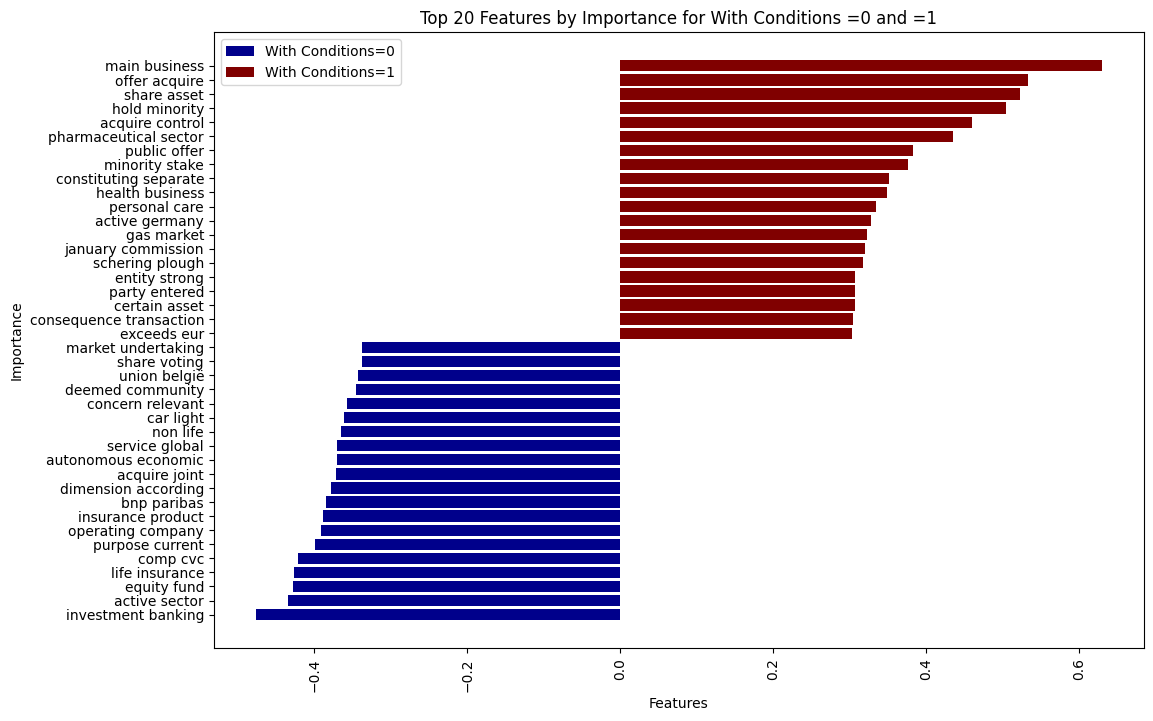

In [34]:
# Sort the features by absolute importance for label=1
df_features_train1 = df_features_train1.sort_values(by='abs_importance', ascending=False)
df_features_train1_top10 = df_features_train1.nlargest(20, 'abs_importance')
df_features_train1_top10 = df_features_train1_top10.sort_values('importance', ascending=True)

# Sort the features by absolute importance for label=0
df_features_train0 = df_features_train0.sort_values(by='abs_importance', ascending=False)
df_features_train0_top10 = df_features_train0.nlargest(20, 'abs_importance')

# Create a combined bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(df_features_train0_top10['feature'], df_features_train0_top10['importance'], color='darkblue', label='With Conditions=0')
ax.barh(df_features_train1_top10['feature'], df_features_train1_top10['importance'], color='maroon', label='With Conditions=1')
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Top 20 Features by Importance for With Conditions =0 and =1')
ax.legend()
plt.xticks(rotation=90)
plt.show()

In [35]:
df_features_train.to_excel('../../../output/tables/features_svm_train_full_wc.xlsx', index=True)